<a href="https://colab.research.google.com/github/bulinayas/Deep-deep-learning/blob/main/%5Bseminar%5Dneuron_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500,>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде - "яблоки и груши":

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("./apples_pears.csv")

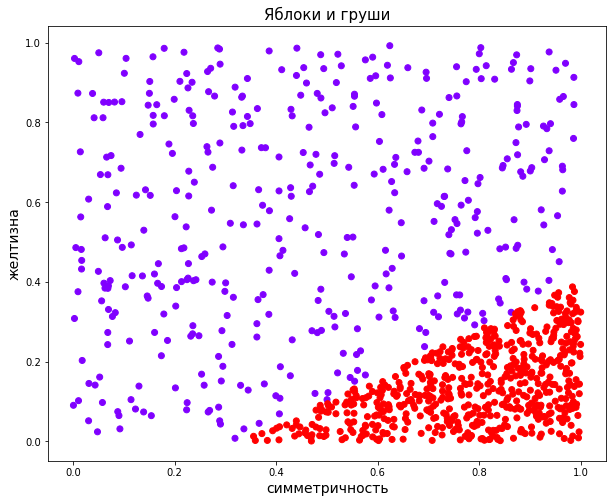

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [ ]:
import torch
from torch.nn import Linear, Sigmoid
from torch.autograd import Variable

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);  ***

Рассмотрим второй путь (он чуть более user-friendly), к первому потом ещё вернёмся, и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [ ]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [ ]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [ ]:
neuron(Variable(torch.FloatTensor([1, 1])))

tensor([0.5536], grad_fn=<SigmoidBackward>)

Предскажем ещё необученным нейроном:

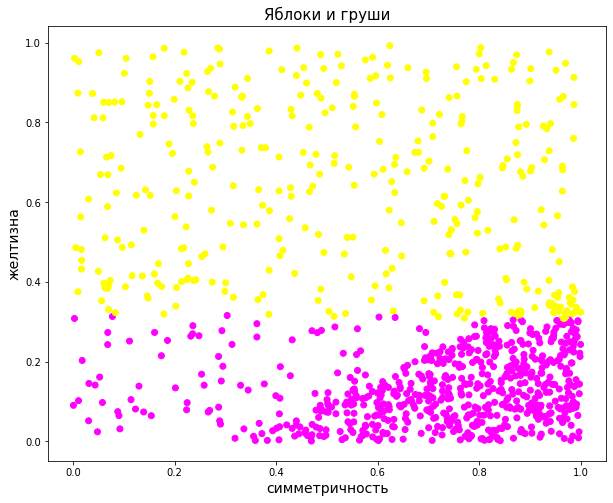

In [ ]:
proba_pred = neuron(Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [ ]:
X = Variable(torch.FloatTensor(X))
y = Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [ ]:
# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3

# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)

# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    #print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 50.35332489013672
1 50.316104888916016
2 50.27899932861328
3 50.24200439453125
4 50.20512771606445
5 50.16835021972656
6 50.131683349609375
7 50.095123291015625
8 50.05866622924805
9 50.0223274230957
10 49.98609161376953
11 49.949954986572266
12 49.91393280029297
13 49.87800598144531
14 49.84218978881836
15 49.806480407714844
16 49.770870208740234
17 49.7353630065918
18 49.69995880126953
19 49.66465377807617
20 49.629451751708984
21 49.59435272216797
22 49.559349060058594
23 49.524444580078125
24 49.48964309692383
25 49.45493698120117
26 49.42033386230469
27 49.38582229614258
28 49.35141372680664
29 49.31709289550781
30 49.28287887573242
31 49.24876022338867
32 49.21472930908203
33 49.180809020996094
34 49.14697265625
35 49.11323165893555
36 49.07957458496094
37 49.046024322509766
38 49.0125617980957
39 48.97918701171875
40 48.9459114074707
41 48.91272735595703
42 48.87963104248047
43 48.84662628173828
44 48.81371307373047
45 48.780887603759766
46 48.74815368652344
47 48.715511322021

Обучили. Предскажем теперь:

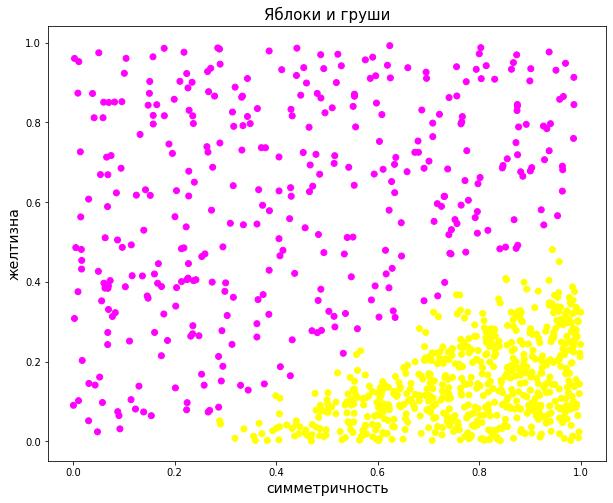

In [ ]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

### Задача 1

1. Как видно по рисунку - качество не идеальное (даже перцептрон на нумпае лучше :). Добейтесь идеального качества (или очень близкого к идеальному), путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации);
2. Используйте функцию потерь `torch.nn.NLLLoss()` (== LogLoss) или `torch.nn.CrossEntropy()`, сделайте вывод о работе нейрона.

In [ ]:
from torch.nn import ReLU
from torch.nn import LeakyReLU
from torch.nn import ELU
from torch.nn import NLLLoss
from torch.nn import CrossEntropyLoss
from torch.nn import Softmax

In [ ]:
neuron=torch.nn.Sequential(
    Linear(in_features=X.shape[1],out_features=2,bias=True),
    #Sigmoid()
    #ReLU()
    #LeakyReLU()
    #ELU()
    Softmax()
)

In [ ]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

In [ ]:
X = Variable(torch.FloatTensor(X))
y = Variable(torch.LongTensor(y.astype(np.int64)).squeeze())

In [ ]:
num_epohs=1000
learning_rate=0.01
loss_f=NLLLoss(size_average=False)
optimizer=torch.optim.SGD(neuron.parameters(),lr=learning_rate)

for i in range(num_epohs):
  y_pred=neuron(X)
  losses=loss_f(y_pred,y)
  print('{} {}'.format(i, losses.data))
  optimizer.zero_grad()
  losses.backward()
  optimizer.step()
y_pred

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 -827.1205444335938
1 -834.8843383789062
2 -841.5318603515625
3 -847.3010864257812
4 -852.3702392578125
5 -856.8679809570312
6 -860.8931884765625
7 -864.5253295898438
8 -867.8232421875
9 -870.8364868164062
10 -873.601806640625
11 -876.1546630859375
12 -878.5186767578125
13 -880.716796875
14 -882.7692260742188
15 -884.6903076171875
16 -886.4942626953125
17 -888.1929931640625
18 -889.7954711914062
19 -891.311279296875
20 -892.747802734375
21 -894.1119995117188
22 -895.410400390625
23 -896.6467895507812
24 -897.8284301757812
25 -898.95703125
26 -900.0377197265625
27 -901.0722045898438
28 -902.06640625
29 -903.0205078125
30 -903.9400024414062
31 -904.82470703125
32 -905.677001953125
33 -906.4984130859375
34 -907.2925415039062
35 -908.060302734375
36 -908.802001953125
37 -909.5195922851562
38 -910.2158813476562
39 -910.8900756835938
40 -911.5447998046875
41 -912.1795043945312
42 -912.7947998046875
43 -913.3951416015625
44 -913.977294921875
45 -914.5443725585938
46 -915.0958862304688
47 -91

tensor([[8.2954e-02, 9.1705e-01],
        [1.7335e-05, 9.9998e-01],
        [5.9711e-03, 9.9403e-01],
        ...,
        [4.3325e-05, 9.9996e-01],
        [1.0000e+00, 1.6369e-10],
        [8.5210e-03, 9.9148e-01]], grad_fn=<SoftmaxBackward>)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


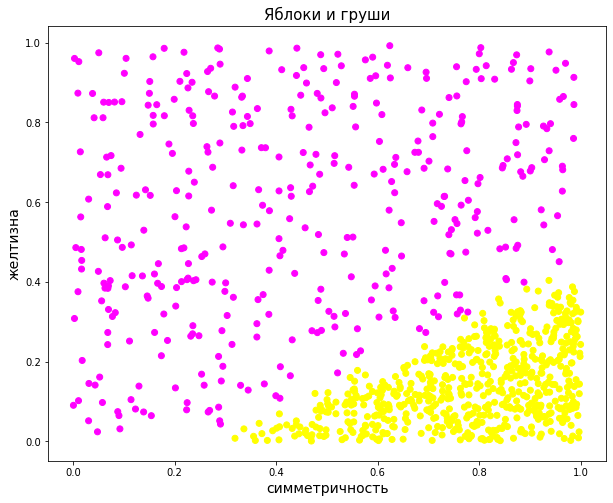

In [ ]:
proba_pred = neuron(X)
y_pred=proba_pred[:,1]>0.5
y_pred = y_pred.data.numpy()

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
num_epohs=1000
learning_rate=0.01
loss_f=CrossEntropyLoss(size_average=False)
optimizer=torch.optim.SGD(neuron.parameters(),lr=learning_rate)

for i in range(num_epohs):
  y_pred=neuron(X)
  losses=loss_f(y_pred,y)
  print('{} {}'.format(i, losses.data))
  optimizer.zero_grad()
  losses.backward()
  optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 337.6271667480469
1 337.2810974121094
2 337.068359375
3 336.9435119628906
4 336.87152099609375
5 336.8305358886719
6 336.80621337890625
7 336.7911682128906
8 336.7808837890625
9 336.77294921875
10 336.7659606933594
11 336.7599182128906
12 336.7540283203125
13 336.74847412109375
14 336.7427062988281
15 336.7372741699219
16 336.7317810058594
17 336.7260437011719
18 336.72064208984375
19 336.71527099609375
20 336.7095947265625
21 336.7040100097656
22 336.6985168457031
23 336.6929931640625
24 336.6876525878906
25 336.6822814941406
26 336.6766052246094
27 336.6711120605469
28 336.6654968261719
29 336.660400390625
30 336.6548767089844
31 336.6492919921875
32 336.6441650390625
33 336.63836669921875
34 336.63299560546875
35 336.62762451171875
36 336.62213134765625
37 336.61688232421875
38 336.6115417480469
39 336.6058349609375
40 336.60064697265625
41 336.59515380859375
42 336.58966064453125
43 336.58428955078125
44 336.5787658691406
45 336.57354736328125
46 336.5682067871094
47 336.56283569

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


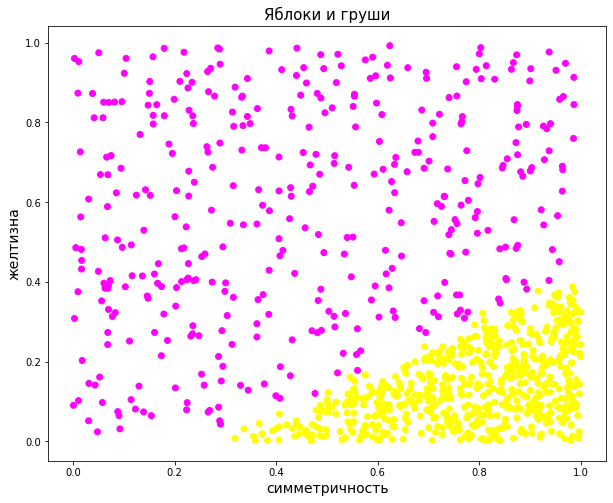

In [ ]:
proba_pred = neuron(X)
y_pred=proba_pred[:,1]>0.5
y_pred = y_pred.data.numpy()

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

In [ ]:
XX = X.data.numpy()
Yy = y.data.numpy()

In [ ]:
h = 0.02
x_min, x_max = XX[:, 0].min(), XX[:, 0].max()
y_min, y_max = XX[:, 1].min(), XX[:, 1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(XX[:, 0], XX[:, 1], c=Yy, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Круто. Нейрон работет, отличает яблоки от груш (Вы ведь этого добились, правда?). Но так ли он силён? Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

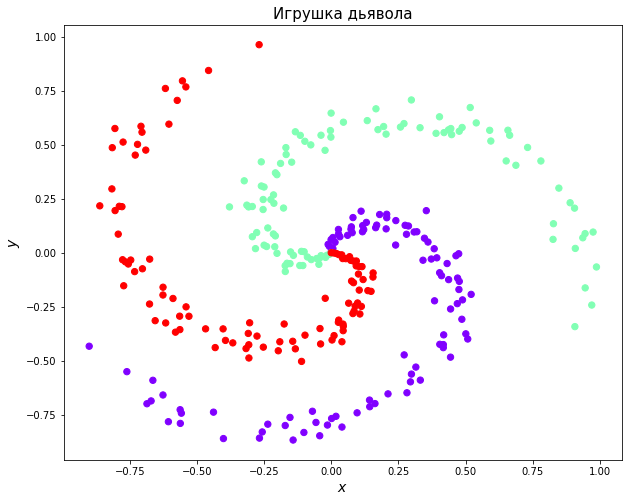

In [ ]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable() (без этого градиенты не посчитать):

In [ ]:
X = Variable(torch.FloatTensor(X))
y = Variable(torch.LongTensor(y.astype(np.int64)))

In [ ]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


В атаку, наш славный нейрон с сигмоидой (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [ ]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    Linear(D_in, D_out),
)

loss_fn = CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    #print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
# Обратно в Numpy для отрисовки
XX = X.data.numpy()
Yy = y.data.numpy()

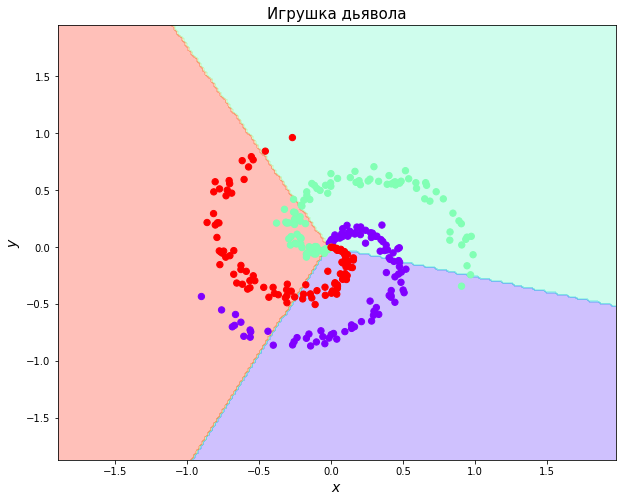

In [ ]:
# Отрисовочна магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = XX[:, 0].min() - 1, XX[:, 0].max() + 1
y_min, y_max = XX[:, 1].min() - 1, XX[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(XX[:, 0], XX[:, 1], c=Yy, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

---

### Задача 2

Меняя все известные Вам способы улучшения нейросети, постарайтесь добиться лучшего качества здесь. (**архитектуру менять нельзя**, мы же хотим добиться победы одним нейроном (слоем)).

In [ ]:
from torch.nn import LogSoftmax
from torch.nn import Tanh
from torch.optim import Adam

In [ ]:
D_in, D_out = 2, 3

neuron = torch.nn.Sequential(
    Linear(D_in, D_out),
    Softmax()
)

num_epohs=100000
learning_rate = 0.005

loss_fn = CrossEntropyLoss(size_average=False)
optimizer = torch.optim.Adam(neuron.parameters(), lr=learning_rate)
for i in range(num_epohs):
    
    y_pred = neuron(X)
    loss = loss_fn(y_pred, y)
    #print('{} {}'.format(i, loss.data))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
XX = X.data.numpy()
Yy = y.data.numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


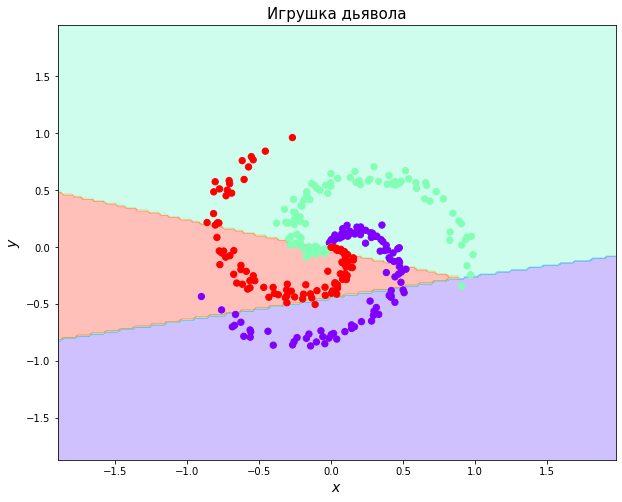

In [ ]:
h = 0.02
x_min, x_max = XX[:, 0].min() - 1, XX[:, 0].max() + 1
y_min, y_max = XX[:, 1].min() - 1, XX[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(XX[:, 0], XX[:, 1], c=Yy, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

---

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*